In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
%load_ext autoreload
%autoreload 0

Notebook by **Maxime Dion** <maxime.dion@usherbrooke.ca><br>
For the QSciTech-QuantumBC virtual workshop on gate-based quantum computing

## Tutorial for  Activity 3.1

For this activity, make sure you can easily import your versions of `hamiltonian.py`, `pauli_string.py` and `mapping.py`. Placing this notebook in the same `path` as these files is the easiest way to acheive this. At the end of this notebook, you should be in good position to complete these 3 files.

The solution we suggest here is NOT mandatory. If you find ways to make it better and more efficient, go on and impress us! On the other hand, by completing all sections of this notebook you be able to :
- Create `PauliString` instances
- Multiply `PauliString` together
- Translate a PauliString into a unitary matrix of size `(2**n)**2` (optionnal)
- Create `LinearCombinaisonPauliString` instances
- Multiply and add `LinearCombinaisonPauliString` together
- Combine repeated `PauliString`s in `LinearCombinaisonPauliString`
- Use the Jordan-Wigner mapping to translate Fermionic Operators in `LinearCombinaisonPauliString`s
- Use the Jordan-Wigner mapping to map a `FermionicHamiltonian` into a `LinearCombinaisonPauliString`.

**Important**

When you modify and save a `*.py` file you need to re-import it so that your modifications can be taken into account when you re-execute a call. By adding the magic command `%autoreload` at the beginning of a cell, you make sure that the modifications you did to the `*.py` files are taken into account when you re-run a celll and that you can see the effect.

If you encounter unusual results, restart the kernel and try again.

**Note on numbering**

When you ask a question in the Slack channel you can refer to the section name or the section number.

To enable the section numbering, please make sure you install [nbextensions](https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/install.html). It is available in the conda distribution. After installation it you need to enable the option 'Table of contents (2)'.

# PauliStrings

The `PauliString` class is partially implemented in the file `PauliString.py`. 

In [2]:
from pauli_string import PauliString

## Creation

This object's attributes are 2 arrays of booleans `z_bits` and `x_bits`. You can easily create an instance and `print` the result. The `__str__` method is already implemented so you can use `print()` on it. The boolean arrays in input are in the `0123` order and the output string is in the reversed `q3q2q1q0` order. Here we initialize the Pauli string `YXZI = -1j*(ZIZI)*(XXII)`.

In [3]:
z_bits = np.array([0,1,0,1],dtype = bool)
x_bits = np.array([0,0,1,1],dtype = bool)
pauli_string = PauliString(z_bits,x_bits)
print(pauli_string)

YXZI


### Creation exercice

Create the `ZZXY` pauli string. Remember that the arrays are in the 0...n order, but the string representation in the reverse order. The `print` should return `ZZXY`.

In [4]:
z_bits = np.array([1,0,1,1], dtype=bool)
x_bits = np.array([1,1,0,0], dtype=bool)
print(PauliString(z_bits,x_bits))

ZZXY


### Creation from string
While this will not be a useful way to create PauliString in the H2 solution, it will be practical for this notebook and for debugging. Implement the `@classmethod` method `from_str` that takes a string like `YXZI` to build a `PauliString`.

In [5]:
%autoreload
pauli_string = PauliString.from_str('YXZI')
print(pauli_string)

YXZI


### Useful methods

In order to compare `PauliString`s together it's convenient to represent it as `zx_bits` which is an array twice as long that combine `z_bits` and `x_bits`. Implement the `to_zx_bits()` method. Why not do the `to_xz_bits()` while your at it!

You should get :

<code>
[False  True False  True False False  True  True]<br>[False False  True  True False  True False  True]
</code>

In [6]:
%autoreload
pauli_string = PauliString.from_str('YXZI')
zx_bits = pauli_string.to_zx_bits()
print(zx_bits)
xz_bits = pauli_string.to_xz_bits()
print(xz_bits)

[False  True False  True False False  True  True]
[False False  True  True False  True False  True]


It's also useful to know where are the $\hat{I}$ in a `PauliString`. Implement the method that does this. You should get 

<code>[ True False False False]</code>

In [7]:
%autoreload
pauli_string = PauliString.from_str('YXZI')
ids = pauli_string.ids()
print(ids)

[ True False False False]


### Create with `zx`

Sometimes it will be convenient to create a `PauliString` from a single array `zx_bits`. Implement the `from_zx_bits()` method in order for this cell to return `YXZI`.

In [8]:
%autoreload
z_bits = np.array([0,1,0,1],dtype = bool)
x_bits = np.array([0,0,1,1],dtype = bool)
zx_bits = np.concatenate((z_bits,x_bits))
pauli_string = PauliString.from_zx_bits(zx_bits)
print(pauli_string)

YXZI


## Multiplication with another PauliString

Multiplying `PauliString`s is essential to be able to translate Fermionic Hamiltonians into a qubit Hamiltonian. 

Before you implement the method that will allow you to do this, you should experiment a bit with how boolean arrays behave. Take a look at methods like `np.dot()`, `np.logical_and()`, `np.logical_or()` and `np.logical_xor()`. In particular, notice that the addition `+` on booleans is not a (mod 2) addition (it's a `logical_or`) and the `np.sum()` method on a boolean array counts the number of 1 and returns an `int`.

In [9]:
bits_1 = np.array([0,1,0,1],dtype = bool)
bits_2 = np.array([0,1,1,1],dtype = bool)
print(bits_1 + bits_2)
print(np.sum(bits_1))
# Experiment
print(np.dot(bits_1, bits_2))
print(np.logical_and(bits_1, bits_2))
print(np.logical_or(bits_1, bits_2))
print(np.logical_xor(bits_1, bits_2))
print(np.sum(np.logical_and(bits_1, bits_2)))    # the "dot product" we need

[False  True  True  True]
2
True
[False  True False  True]
[False  True  True  True]
[False False  True False]
2


With these considarations, implement the `mul_pauli_string(PauliString)` method in order to replicate the product

\begin{align}
\hat{I}\hat{Y}\hat{Z}\hat{Z} \times \hat{I}\hat{I}\hat{X}\hat{Z}  = i \hat{I}\hat{Y}\hat{Y}\hat{I}.
\end{align}

The product return a `PauliString` and a phase (`complex`). The method `__mul__(other)` is already implemeted to call `mul_pauli_string()` so you can use `*` to do the product.

In [10]:
%autoreload
pauli_string_1 = PauliString.from_str('IYZZ')
pauli_string_2 = PauliString.from_str('IIXZ')
new_pauli_string, phase = pauli_string_1 * pauli_string_2
print(new_pauli_string, phase)

IYYI 1j


Check your solution on many pairs of Pauli strings like 

\begin{align}
\hat{Z}\hat{Z}\hat{Z}\hat{Z} \times \hat{X}\hat{X}\hat{X}\hat{I}  = -i \hat{Y}\hat{Y}\hat{Y}\hat{Z}.
\end{align}

In [11]:
%autoreload
pauli_string_1 = PauliString.from_str('ZZZZ')
pauli_string_2 = PauliString.from_str('XXXI')
new_pauli_string, phase = pauli_string_1 * pauli_string_2
print(new_pauli_string, phase)

YYYZ (-0-1j)


## Matrix representation (optional)
The matrix reprensetation of `PauliString` will only be used to compute the exact solution of the Hamiltonian. It will not be used for quantum computing, but it's a nice way to validate your results.

Any Pauli string can be converted into a matrix. This is useful to find the exact solution for small systems. To combine the space of two qubits we use the [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) ($\otimes$). For example, the `ZX` pauli string can be represented as the following matrix

\begin{align}
    \hat{Z}_1\hat{X}_0 = \hat{Z}_1\otimes\hat{X}_0 &= \begin{pmatrix} 1 \times \hat{X}_0 & 0 \\ 0 & -1 \times \hat{X}_0 \end{pmatrix} \\
    &= \begin{pmatrix} 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & -1 \\ 0 & 0 & -1 & 0 \end{pmatrix}
\end{align}

which is expressed in the basis

\begin{align}
    |00\rangle, |01\rangle, |10\rangle, |11\rangle.
\end{align} 

Indeed we verify that

\begin{align}
    \hat{Z}_1\hat{X}_0 |10\rangle &= - |11\rangle \\
    \begin{pmatrix} 0 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \\ 0 & 0 & 0 & -1 \\ 0 & 0 & -1 & 0 \end{pmatrix}\begin{pmatrix} 0 \\ 0 \\ 1 \\ 0 \end{pmatrix} &= -\begin{pmatrix} 0 \\ 0 \\ 0 \\ 1 \end{pmatrix}
\end{align}

The `np.kron()` method is a good way to acheive this. The previous 2 Pauli string can be turned into a $4\times 4$ matrix like this.

In [12]:
z_matrix = np.array([[1,0],[0,-1]],dtype = int)
x_matrix = np.array([[0,1],[1,0]],dtype = int)
print(z_matrix)
print(x_matrix)
zx_matrix = np.kron(z_matrix,x_matrix)
print(zx_matrix)


[[ 1  0]
 [ 0 -1]]
[[0 1]
 [1 0]]
[[ 0  1  0  0]
 [ 1  0  0  0]
 [ 0  0  0 -1]
 [ 0  0 -1  0]]


Implement the `to_matrix()` method for any Pauli string and try it to find the matrix form of `ZX`.

In [13]:
%autoreload
pauli_string = PauliString.from_str('ZX')
print(pauli_string)
matrix = pauli_string.to_matrix()
print(matrix)

ZX
[[ 0.+0.j  1.+0.j  0.+0.j  0.+0.j]
 [ 1.+0.j  0.+0.j  0.+0.j  0.+0.j]
 [ 0.+0.j  0.+0.j -0.+0.j -1.+0.j]
 [ 0.+0.j  0.+0.j -1.+0.j -0.+0.j]]


# LinearCombinaisonPauliString
The `LinearCombinaisonPauliString` class is partially implemented in the file `pauli_string.py`. We will use `LCPS` for short.

In [14]:
from pauli_string import LinearCombinaisonPauliString

## Creation
To build a `LCPS` you only need to provide an `numpy.array` of coefficients (`complex`) and a `numpy.array` of PauliString. If they are not arrays, they will be converted. Here again the `__str__()` method is already implemented.

In [15]:
coefs = np.array([0.5,0.5],dtype=complex)
pauli_string_1 = PauliString.from_str('IIXZ')
pauli_string_2 = PauliString.from_str('IYZZ')
pauli_strings = np.array([pauli_string_1,pauli_string_2], dtype=PauliString)
lcps = LinearCombinaisonPauliString(coefs,pauli_strings)
print(lcps)

2 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+0.50000,+0.00000)
IYZZ (+0.50000,+0.00000)


### Multiplication of a PauliString by a coefficient
Multiplying a `PauliString` by a number is a useful way to create a `LCPS` with only 1 `PauliStrin`. Implement the method `mul_coef` in the `PauliString` class so that you can easily create a `LCPS`.

In [16]:
%autoreload
lcps_single = 1*PauliString.from_str('IIXZ')
print(lcps_single)

1 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+1.00000,+0.00000)


### Addition of LCPSs
The sum of two `LCPS`s is just the union of these two ensembles. Implement `add_pauli_string_linear_combinaison(LCPS)` and test your solution here. The `__add__()` method is already implemented to call `add_pauli_string_linear_combinaison(LCPS)` so you can use the `+` operator.

In [17]:
%autoreload
lcps = 0.5*pauli_string_1 + 0.5*pauli_string_2
print(lcps)

2 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+0.50000,+0.00000)
IYZZ (+0.50000,+0.00000)


### Product of LCPSs
The product of two LCPSs can be computed using the distributive property of any sum. While you implement `mul_linear_combinaison_pauli_string` make sure you take into account the phase coming from the product of two PauliStrings. You can test your code on the following cell.

In [18]:
%autoreload
lcps_1 = 1*PauliString.from_str('IIXZ')
lcps_2 = 1*PauliString.from_str('IYZZ')
new_lcps = lcps_1 * lcps_2
print(new_lcps)

1 pauli strings for 4 qubits (Real, Imaginary)
IYYI (+0.00000,-1.00000)


You should get:

<code>
1 pauli strings for 4 qubits (Real, Imaginary)<br>IYYI (+0.00000,-1.00000)
</code>

With addition and multiplication, LCPSs are much more convenient to work with than PauliStrings because they carry the possible phase from the product.

## Accessing subset of a LCPS
A `__getitem__()` method is already implemented to access subset of the `LCPS`. You can use indices and slices, like a `list` or an `np.array`.

In [19]:
lcps = 1*PauliString.from_str('IIIZ') + 1*PauliString.from_str('IIZI') + 1*PauliString.from_str('IZII') + 1*PauliString.from_str('ZIII')
print(lcps[0])
print(lcps[1:3])
print(lcps[-1])
print(lcps[np.array([False, True, True, False])])

1 pauli strings for 4 qubits (Real, Imaginary)
IIIZ (+1.00000,+0.00000)
2 pauli strings for 4 qubits (Real, Imaginary)
IIZI (+1.00000,+0.00000)
IZII (+1.00000,+0.00000)
1 pauli strings for 4 qubits (Real, Imaginary)
ZIII (+1.00000,+0.00000)
2 pauli strings for 4 qubits (Real, Imaginary)
IIZI (+1.00000,+0.00000)
IZII (+1.00000,+0.00000)


## Useful methods
Your already implemented `to_zx_bits`, `to_xz_bits` and `ids` for the PauliString. Implement similar methods for LCPS where the bits are stored in a dim = 2 array.

In [20]:
%autoreload
print('zx_bits')
zx_bits = lcps.to_zx_bits()
print(zx_bits)

zx_bits
[[ True False False False False False False False]
 [False  True False False False False False False]
 [False False  True False False False False False]
 [False False False  True False False False False]]


In [21]:
%autoreload
print('xz_bits')
xz_bits = lcps.to_xz_bits()
print(xz_bits)

xz_bits
[[False False False False  True False False False]
 [False False False False False  True False False]
 [False False False False False False  True False]
 [False False False False False False False  True]]


In [22]:
%autoreload
print('ids')
ids = lcps.ids()
print(ids)

ids
[[False  True  True  True]
 [ True False  True  True]
 [ True  True False  True]
 [ True  True  True False]]


## Combinaison and threshold
When a `PauliString` is present many times in a LCPS, it is convenient to be able to remove extra occurences by combining the respective coefficients. Let's take the example from the presentation.

In [23]:
lcps_1 = 1*PauliString.from_str('IIIZ') + -0.5*PauliString.from_str('IIZZ') 
lcps_2 = 1*PauliString.from_str('ZZZI') + 0.5*PauliString.from_str('ZZII') 
lcps_3 = lcps_1 * lcps_2
print(lcps_3)

4 pauli strings for 4 qubits (Real, Imaginary)
ZZZZ (+1.00000,+0.00000)
ZZIZ (+0.50000,+0.00000)
ZZIZ (-0.50000,+0.00000)
ZZZZ (-0.25000,+0.00000)


We see that `ZZZZ` occurs 2 times and `ZZIZ` occurs 2 times as well.

Implement the `combine()` method to reduce the `LCPS` to 2 `PauliString`s. There are many ways to do that. Suggestion, convert with `to_zx_bits` and use the `np.unique()` method. DO NOT remove `PauliString`s with `0` coef yet.

In [24]:
%autoreload
lcps_combined = lcps_3.combine()
print(lcps_combined)

2 pauli strings for 4 qubits (Real, Imaginary)
ZZIZ (+0.00000,+0.00000)
ZZZZ (+0.75000,+0.00000)


You should get:

<code>
2 pauli strings for 4 qubits (Real, Imaginary)<br>ZZIZ (+0.00000,+0.00000)<br>ZZZZ (+0.75000,+0.00000)
</code>

Implement the `apply_threshold` method to get rid of any Pauli string with a coefficient smaller than the `threshold`.

In [25]:
%autoreload
lcps = lcps_combined.apply_threshold()
print(lcps)

1 pauli strings for 4 qubits (Real, Imaginary)
ZZZZ (+0.75000,+0.00000)


You should get:

<code>
1 pauli strings for 4 qubits (Real, Imaginary)<br>ZZZZ (+0.75000,+0.00000)
</code>

## Sort
The resulting LCPS after `combine` and `apply_threshold` can be pretty random. It's useful to be able to sort. We suggest you implement the `sort` method using the `zx_bits`.

In [26]:
%autoreload
lcps = (lcps_1 + lcps_2).sort()
print(lcps)

4 pauli strings for 4 qubits (Real, Imaginary)
IIIZ (+1.00000,+0.00000)
IIZZ (-0.50000,+0.00000)
ZZII (+0.50000,+0.00000)
ZZZI (+1.00000,+0.00000)


## Matrix representation (optional)

The LCPS can be represented as a matrix. This matrix is just the linear combinaison of the matrices representing each Pauli string. Implement the `to_matrix()` method.

In [27]:
%autoreload
small_lcps = 1*PauliString.from_str('ZZ') + 2*PauliString.from_str('XX')
matrix = small_lcps.to_matrix()
print(matrix)

[[ 1.+0.j  0.+0.j  0.+0.j  2.+0.j]
 [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j]
 [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j]
 [ 2.+0.j  0.+0.j  0.+0.j  1.+0.j]]


You should get :

<code>
[[ 1.+0.j  0.+0.j  0.+0.j  2.+0.j]<br> [ 0.+0.j -1.+0.j  2.+0.j  0.+0.j]<br> [ 0.+0.j  2.+0.j -1.+0.j  0.+0.j]<br> [ 2.+0.j  0.+0.j  0.+0.j  1.+0.j]] 
</code>

# Mapping
You are now in good position to implement your first mapping. The abstract class `Mapping` and the class `JordanWigner` are partially implemented in the file `Mapping.py`.

In [28]:
from mapping import JordanWigner

## Jordan-Wigner
The goal of the mapping is to translate creation and annihilation fermionic operator into `LinearCombinaisonPauliString`. You now need to implement `fermionic_operator_linear_combinaison_pauli_string()` of the `JordanWigner` class. It should return 2 lists of `LinearCombinaisonPauliString`s, one `list` for the 4 creation operators and one `list` for the 4 annihilation operators. You can make use of the addition and multipliation method you implemented earlier.

Refer to the presentation of activity 3.1 for the general structure of the Jordan-Wigner mapping. Make sure your method works for different numbers of qubits.

In [29]:
%autoreload
mapping = JordanWigner()
aps, ams = mapping.fermionic_operator_linear_combinaison_pauli_string(4)
print(len(aps), 'creation operators')
print(len(ams), 'annihilation operators')

print('Creation operators')
for ap in aps:
    print(ap)
print()
print('Annihilation operators')
for am in ams:
    print(am)

4 creation operators
4 annihilation operators
Creation operators
2 pauli strings for 4 qubits (Real, Imaginary)
IIIX (+0.50000,+0.00000)
IIIY (-0.00000,-0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+0.50000,+0.00000)
IIYZ (-0.00000,-0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
IXZZ (+0.50000,+0.00000)
IYZZ (-0.00000,-0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
XZZZ (+0.50000,+0.00000)
YZZZ (-0.00000,-0.50000)

Annihilation operators
2 pauli strings for 4 qubits (Real, Imaginary)
IIIX (+0.50000,+0.00000)
IIIY (+0.00000,+0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+0.50000,+0.00000)
IIYZ (+0.00000,+0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
IXZZ (+0.50000,+0.00000)
IYZZ (+0.00000,+0.50000)
2 pauli strings for 4 qubits (Real, Imaginary)
XZZZ (+0.50000,+0.00000)
YZZZ (+0.00000,+0.50000)


For the creation operators you should get.

<code>
Creation operators<br>2 pauli strings for 4 qubits (Real, Imaginary)<br>IIIX (+0.50000,+0.00000)<br>IIIY (-0.00000,-0.50000)<br>2 pauli strings for 4 qubits (Real, Imaginary)
IIXZ (+0.50000,+0.00000)<br>IIYZ (-0.00000,-0.50000)<br>2 pauli strings for 4 qubits (Real, Imaginary)<br>IXZZ (+0.50000,+0.00000)<br>IYZZ (-0.00000,-0.50000)<br>2 pauli strings for 4 qubits (Real, Imaginary)<br>XZZZ (+0.50000,+0.00000)<br>YZZZ (-0.00000,-0.50000)
</code>

For the annihilation just reverse the sign of the imaginary part.

## Molecular Hamiltonian Check

To map the H2 `MolecularFermionicHamiltonian` we first need to get the integral tensors. You can use either one of the two solutions presented here depending on how succesful you were with the installation of the now infamous `pyscf` module.

- The first method will make use of `pyscf` to build the molecule and of the `from_pyscf_mol` method you have implemented from day 2.

- The second method will simply load the integral tensors from a file. We provide this file for a H2 molecule with a distance of 0.735 Angstroms. Even if you are using the first method, you can use this one to compare your tensor to the ones provided. In particuler, the two-body tensor can be a bit tricky to get right!

### Building the molecule with pyscf

**note** If you were not able to properly install and run `pyscf` on your computer, please skip this section.

Before going further, we need to make sure your `MolecularFermionicHamiltonian` implementation in `hamiltonian.py` is correct. By now you should be able to run the following cell to build a molecule with pyscf and convert it into a Fermionic Hamiltonian.

In [30]:
%autoreload
from pyscf import gto
from hamiltonian import MolecularFermionicHamiltonian

In [31]:
distance = 0.735 #units in AA
mol = gto.M(
    atom = [['H', (0,0,-distance/2)], ['H', (0,0,distance/2)]], 
    basis = 'sto-3g'
    )
molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
print(molecular_hamiltonian_no_spin)

Fermionic Hamiltonian
Number of orbitals : 2
Including spin : False


You should be able to access the integral tensors to check if their values are correct. The `get_integrals` methods for each Hamiltonian are already implemented.

In [32]:
h1_no_spin, h2_no_spin = molecular_hamiltonian_no_spin.get_integrals()

In [33]:
print(h1_no_spin)

[[-1.25633907  0.        ]
 [ 0.         -0.47189601]]


Depending on the basis you've chosen, you should get

<code>
[[-1.25633907  0.        ]<br> [ 0.         -0.47189601]]
</code>

If you have a different order, we strongly suggest to modify your implementation of the `from_pyscf_mol()` to your order matches this one. Getting the order of the eigenvalues with `numpy.argsort` and reorganizing the eigenvalues and the eigenvectors usually does the trick.

The `h2` tensor is large to look at. We will check its validity in next section.

**note** If you want to save the integrals into a file you can use something like the following cell. Saving the atom configuration, the basis and the nuclear energy can be useful.

In [34]:
with open('my_file.npz','wb') as f:
    np.savez(f, atom=mol.atom, basis=mol.basis, energy_nuc=mol.energy_nuc(), h1=h1_no_spin, h2=h2_no_spin)

/Users/bhenders/opt/miniconda3/envs/qiskit/lib/python3.8/site-packages/numpy/core/_asarray.py:136: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order, subok=True)


### Loading the integrals from a file

The file containing the integrals is named `Integrals_sto-3g_H2_d_0.7350_no_spin.npz`. These integrals are already in the molecular basis but the spin bas not been included yet. Make sure it's present in the same path is this notebook or change the access path in `open` to reach it. To load the integrals just run the following cell.

In [35]:
with open('Integrals_sto-3g_H2_d_0.7350_no_spin.npz','rb') as f:
    out = np.load(f, allow_pickle=True)
    h1_load_no_spin = out['h1']
    h2_load_no_spin = out['h2']
    
print(h1_load_no_spin)

[[-1.25633907  0.        ]
 [ 0.         -0.47189601]]


By the way, this `npz` also contains files with the `basis`, the `atom` and `energy_nuc` names. While `atom` describes the position of the H atoms `energy_nuc` gives the Coulomb repulsion energy between the nuclei. You can only access it if you `allow_pickle` in the `load` method (check [here](https://numpy.org/devdocs/reference/generated/numpy.load.html) for more details on that). 

**Note** If you built your tensor on your own you can check that yours are equivalent to the ones in the file. If you didn't, just skip this cell. If your integrals are different, maybe you should check you implementation of `from_pyscf_mol` before going further.

In [36]:
np.allclose(h1_no_spin, h1_load_no_spin)

True

In [37]:
np.allclose(h2_no_spin, h2_load_no_spin)

True

All we need to do now is put this into a `MolecularFermionicHamiltonian` with the `from_integrals` method.

In [38]:
molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_integrals(h1_load_no_spin,h2_load_no_spin)

### Add the spin

Last step to make the `MolecularFermionicHamiltonian` complete is to include the spin to double the number of basis states.

In [39]:
molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()

This method is doing a [Kronecker product](https://en.wikipedia.org/wiki/Kronecker_product) between the integral tensors in the orbital space with the spin space. Since spin up and spin down are only just a copy of one an other, we simply use a identity matrix.

\begin{align}
    \mathbb{I}_{mn}^{\text{spin}} \otimes h_{st}^{(1) \text{orbital}} &= 
    \begin{pmatrix} 1_\uparrow & 0 \\ 0 & 1_\downarrow  \end{pmatrix}\otimes \begin{pmatrix} E_g & 0 \\ 0 & E_u \end{pmatrix} \\
    &= \begin{pmatrix} 1_\uparrow \times h^{(1) \text{orbital}} & 0 \\ 0 & 1_\downarrow \times h^{(1) \text{orbital}} \end{pmatrix} \\
    h_{ij}^{(1) \text{spin-orbital}} &= \begin{pmatrix} E_{g\uparrow} & 0 & 0 & 0 \\ 0 & E_{u\uparrow} & 0 & 0 \\ 0 & 0 & E_{g\downarrow} & 0 \\ 0 & 0 & 0 & E_{u\downarrow} \end{pmatrix}
\end{align}

The index $m$, $n$, $s$ and $t$ can all take the values `0` and `1`. The Kronecker product combines $m$ and $s$ together to form $i$ while $n$ and $t$ are combined together to form $j$. Both $i$ and $j$ can now take 4 different values therefore the $4\times4$ matrix. The $\uparrow$ and $\downarrow$ in subscript are only there to identify each one belongs to which spin. In the end the values $E_{g\uparrow} = E_{g\downarrow} = E_{g}$ and $E_{u\uparrow} = E_{u\downarrow} = E_{u}$.

This a little more complex for the 2 body term because the tensor is of dimension 4. 

\begin{align}
    \mathbb{I}_{mn}\mathbb{I}_{pq} \otimes h_{stuv}^{(2) \text{orbital}} &= h_{ijkl}^{(2) \text{spin-orbital}} 
\end{align}

Obsiously we cannot easily write this! But here the indices are combined like so

\begin{align}
    (m,s) \to i, (n,t) \to j, (p,u) \to k, (q,v) \to l.
\end{align}

And if that is not complicated enough this when the $h_{stuv}^{(2) \text{orbital}}$ is given in the physicist notation. Remember that you can go from one notation to the other by simply using

<code>
    h2_physicist = np.einsum('ijkl->iklj',h2_chemist)
</code>

or 
<code>
    h2_chemist = np.einsum('iklj->ijkl',h2_physicist)
</code>

## Building the Qubit Hamiltonian
The translation from a fermionic Hamltonian to a qubit Hamiltonian depends on the kind of Hamiltonian. That's why we will implement a version of the `to_linear_combinaison_pauli_string()` method for `OneBodyFermionicHamiltonian` and for `TwoBodyFermionicHamiltonian`. All we need to provide are the creation/annhilation operators you generated in the Jordan-Wigner section. 

### One body term
Let's start with the one_body part. The one body Hamiltonian is of the form 
\begin{align}
    \mathcal{H}_1 = \sum_{i,j} h_{ij} \hat{a}_i^\dagger \hat{a}_j
\end{align} 

You should now be able to implement the `to_linear_combinaison_pauli_string(aps,ams)` method for the `OneBodyFermionicHamiltonian` class in the `Hamiltonian.py` file. 

Each fermionic operator is made of 2 Pauli strings. So each term $i,j$ creates 4 Pauli strings. There is 16 terms in $h_{ij}$ so there is 64 Pauli strings (if we do not consider combinaison and applying threshold yet). Your implementation should now return a LCPS of length 64.

In [40]:
%autoreload
print(lcps * np.array([1,2,2,1]))

4 pauli strings for 4 qubits (Real, Imaginary)
IIIZ (+1.00000,+0.00000)
IIZZ (-1.00000,+0.00000)
ZZII (+1.00000,+0.00000)
ZZZI (+1.00000,+0.00000)


In [41]:
%autoreload
h1_lcps = molecular_hamiltonian.one_body.to_linear_combinaison_pauli_string(aps, ams)
print(len(h1_lcps))

64


We see many Pauli strings with 0 coefficient as well as many repeated strings. We can now exploit `combine()` and `apply_threshold()`. Since there is many 0 terms already we do `apply_threshold()` first, then `combine()` and `apply_threshold()` again if there was any cancellations. We can finish with `sort()` for neat presentation.

In [42]:
h1_lcps = h1_lcps.combine().apply_threshold().sort()
print(h1_lcps)

5 pauli strings for 4 qubits (Real, Imaginary)
IIII (-1.72824,+0.00000)
IIIZ (+0.62817,+0.00000)
IIZI (+0.23595,+0.00000)
IZII (+0.62817,+0.00000)
ZIII (+0.23595,+0.00000)


You should get :

<code>
5 pauli strings for 4 qubits (Real, Imaginary)
IIII (-1.72824,+0.00000)
IIIZ (+0.62817,+0.00000)
IIZI (+0.23595,+0.00000)
IZII (+0.62817,+0.00000)
ZIII (+0.23595,+0.00000)
</code>

**Note** : You can add these steps at the end of your `one_body.to_linear_combinaison_pauli_string` to automatically reduce the number of Pauli strings.

### Two body term
The two body Hamiltonian is of the following form :
\begin{align}
    \mathcal{H}_2 = \frac{1}{2}\sum_{i,j} h_{ijkl} \hat{a}_i^\dagger\hat{a}_j^\dagger \hat{a}_k\hat{a}_l
\end{align} 
You can now implement the `to_linear_combinaison_pauli_string()` method for the `TwoBodyFermionicHamiltonian` class in the `Hamiltonian.py` file. 
Counting all Pauli strings you should produce 4096 Pauli strings.

In [43]:
%autoreload
h2_lcps = molecular_hamiltonian.two_body.to_linear_combinaison_pauli_string(aps, ams)
print(len(h2_lcps))

4096


Applying the `combine` and `apply_threshold` this reduce to 15 Pauli strings!

In [44]:
h2_lcps = h2_lcps.combine().apply_threshold().sort()
print(h2_lcps)

15 pauli strings for 4 qubits (Real, Imaginary)
IIII (+0.91769,+0.00000)
IIIZ (-0.45599,+0.00000)
IIZI (-0.46170,+0.00000)
IIZZ (+0.12091,+0.00000)
IZII (-0.45599,+0.00000)
IZIZ (+0.16893,+0.00000)
IZZI (+0.16615,+0.00000)
ZIII (-0.46170,+0.00000)
ZIIZ (+0.16615,+0.00000)
ZIZI (+0.17464,+0.00000)
ZZII (+0.12091,+0.00000)
XXXX (+0.04523,+0.00000)
XXYY (+0.04523,+0.00000)
YYXX (+0.04523,+0.00000)
YYYY (+0.04523,+0.00000)


You should get :

<code>
15 pauli strings for 4 qubits (Real, Imaginary)<br>IIII (+0.91769,+0.00000)<br>IIIZ (-0.45599,+0.00000)<br>IIZI (-0.46170,+0.00000)<br>IIZZ (+0.12091,+0.00000)<br>IZII (-0.45599,+0.00000)<br>IZIZ (+0.16893,+0.00000)<br>IZZI (+0.16615,+0.00000)<br>ZIII (-0.46170,+0.00000)<br>ZIIZ (+0.16615,+0.00000)<br>ZIZI (+0.17464,+0.00000)<br>ZZII (+0.12091,+0.00000)<br>XXXX (+0.04523,+0.00000)<br>XXYY (+0.04523,+0.00000)<br>YYXX (+0.04523,+0.00000)<br>YYYY (+0.04523,+0.00000)
</code>

### Molecular Hamiltonian
The molecular Hamiltonian is just the sum of the one and two body terms. Implement this function in `MolecularFermionicHamiltonian`. You should now be able to run this code.

In [45]:
%autoreload
htot_lcps = molecular_hamiltonian.to_linear_combinaison_pauli_string(aps, ams)
htot_lcps = htot_lcps.combine().apply_threshold().sort()
print(htot_lcps)

15 pauli strings for 4 qubits (Real, Imaginary)
IIII (-0.81055,+0.00000)
IIIZ (+0.17218,+0.00000)
IIZI (-0.22575,+0.00000)
IIZZ (+0.12091,+0.00000)
IZII (+0.17218,+0.00000)
IZIZ (+0.16893,+0.00000)
IZZI (+0.16615,+0.00000)
ZIII (-0.22575,+0.00000)
ZIIZ (+0.16615,+0.00000)
ZIZI (+0.17464,+0.00000)
ZZII (+0.12091,+0.00000)
XXXX (+0.04523,+0.00000)
XXYY (+0.04523,+0.00000)
YYXX (+0.04523,+0.00000)
YYYY (+0.04523,+0.00000)


You should get :

<code>
15 pauli strings for 4 qubits (Real, Imaginary)<br>IIII (-0.81055,+0.00000)<br>IIIZ (+0.17218,+0.00000)<br>IIZI (-0.22575,+0.00000)<br>IIZZ (+0.12091,+0.00000)<br>IZII (+0.17218,+0.00000)<br>IZIZ (+0.16893,+0.00000)<br>IZZI (+0.16615,+0.00000)<br>ZIII (-0.22575,+0.00000)<br>ZIIZ (+0.16615,+0.00000)<br>ZIZI (+0.17464,+0.00000)<br>ZZII (+0.12091,+0.00000)<br>XXXX (+0.04523,+0.00000)<br>XXYY (+0.04523,+0.00000)<br>YYXX (+0.04523,+0.00000)<br>YYYY (+0.04523,+0.00000)
</code>

## You have completed your first mapping of H2!
What now? The next step is to use this mapping to evaluate the Hamiltonian on a quantum computer. This is the topic of activity 3.2.

## Bonus
In the process we built the `to_matrix()` method. Applying it to the `htot_lcps` will give you the matrix representation of the whole molecular Hamiltonian. You can find the exact solution to this Hamiltonian by diagonalizing this matrix. The lowest eigenvalue and its associated eigenvector are the ground state energy/state vector.

Now you could use a `for` loop over an array of distances (say from 0.3 A to 2.5 A) to successively build H2 molecules, map each one to a `LCPS` and finally to a matrix to find its ground state. You could plot the dissociation curve of the H2 molecule. Just don't forget to add the nucleus-nucleus energy that you can get from `mol.energy_nuc()`.


Notebook by **Maxime Dion** <maxime.dion@usherbrooke.ca><br>
For the QSciTech-QuantumBC virtual workshop on gate-based quantum computing

In [46]:
%autoreload
n = 50
distances = np.linspace(0.3, 2.5, n)
gs_energies = np.zeros(n)

# Jordan-Wigner Mapping of 4 states to 4 qubits
aps, ams = mapping.fermionic_operator_linear_combinaison_pauli_string(4)

for i, distance in enumerate(distances): #units in AA
    print('Trying Distance '+str(i+1), end="\r")
    mol = gto.M(
        atom = [['H', (0,0,-distance/2)], ['H', (0,0,distance/2)]], 
        basis = 'sto-3g'
        )
    
    # build the molecular Hamiltonian
    molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()
    
    # map the Hamiltonian to a LCPS
    htot_lcps = molecular_hamiltonian.to_linear_combinaison_pauli_string(aps, ams)
    htot_lcps = htot_lcps.combine().apply_threshold().sort()
    
    # diagonalize the Hamiltonian to get energies
    Eh2, _ = np.linalg.eigh(htot_lcps.to_matrix())
    
    gs_energies[i] = Eh2[0] + mol.energy_nuc()
print("Done!                   ", end="\r")

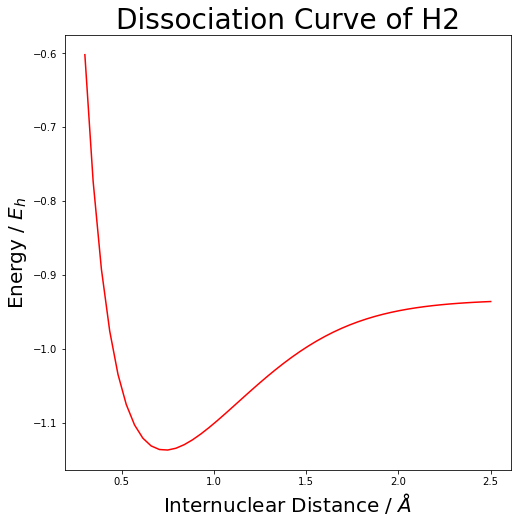

In [47]:
# plot dissociation curve of H2
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(distances, gs_energies, 'r')
ax.set_xlabel(r'Internuclear Distance / $\AA$', fontsize=20)
ax.set_ylabel('Energy / $E_h$', fontsize=20)
ax.set_title('Dissociation Curve of H2', fontsize=28)
# fig.savefig('H2_classical.png')
plt.show()

### Try the Same with LiH

In [48]:
%autoreload
n = 30
distances = np.linspace(0.5, 4, n)
gs_energies = np.zeros(n)

# Just ignore the p orbitals for now to see if it will run
small_basis = gto.basis.parse('''
Li    S
      0.3683820000E+02       0.6966866381E-01
      0.5481720000E+01       0.3813463493E+00
      0.1113270000E+01       0.6817026244E+00
Li    S
      0.5402050000E+00      -0.2631264058E+00
      0.1022550000E+00       0.1143387418E+01
''')

# Jordan-Wigner Mapping of 6 states to 6 qubits
aps, ams = mapping.fermionic_operator_linear_combinaison_pauli_string(6)

for i, distance in enumerate(distances): #units in AA
    print('Trying Distance '+str(i+1), end="\r")
    mol = gto.M(
        atom = [['H', (0,0,-distance/2)], ['Li', (0,0,distance/2)]], 
        basis = {'H': 'sto-3g', 'Li': small_basis}
        )
    
    # build the molecular Hamiltonian
    molecular_hamiltonian_no_spin = MolecularFermionicHamiltonian.from_pyscf_mol(mol)
    molecular_hamiltonian = molecular_hamiltonian_no_spin.include_spin()
    
    # map the Hamiltonian to a LCPS
    htot_lcps = molecular_hamiltonian.to_linear_combinaison_pauli_string(aps, ams)
    htot_lcps = htot_lcps.combine().apply_threshold().sort()
    
    # diagonalize the Hamiltonian to get energies
    Eh2, _ = np.linalg.eigh(htot_lcps.to_matrix())
    
    gs_energies[i] = Eh2[0] + mol.energy_nuc()
print("Done!                   ")

Done!                   


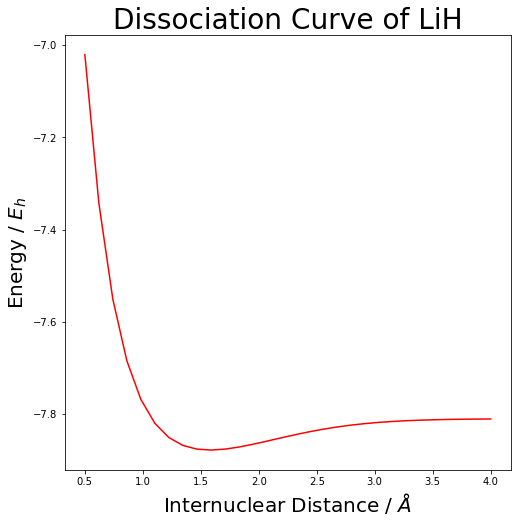

In [51]:
# plot dissociation curve of LiH
fig, ax = plt.subplots(1, 1, figsize=(8,8))
ax.plot(distances, gs_energies, 'r')
ax.set_xlabel(r'Internuclear Distance / $\AA$', fontsize=20)
ax.set_ylabel('Energy / $E_h$', fontsize=20)
ax.set_title('Dissociation Curve of LiH', fontsize=28)
# fig.savefig('LiH_classical.png')
plt.show()